# Import modules

In [16]:
# Data Handlers
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, IterableDataset  # Dataset manager

# Other
from tqdm import tqdm
import os
from pathlib import Path

# Graphics
from matplotlib import pyplot as plt
import seaborn as sns

# Additional modules
from dataset_creator import generate_csv
from assistive_funcs import filtering_image, check_ssim, convert_to_grayscale
from csv_dataloader import get_train_test_data
from math import floor


sns.set()

# Define constants

In [17]:
# Paths
main_data_path = Path("../data")
models_path = Path("../models")

scv_folder = main_data_path / "csv_files" # datasets_path
img_path = main_data_path / "images"

# Generate Dataset

In [18]:
create_dataset = 1
if create_dataset:
    generate_csv(win_size=5, dump_to_file=10000, step=1)

Borders were added, indexes were created. Passed time = 2.04s
Dataset created.               
Total spent time = 171.57s
Total samples = 3696640
Dataset name 'W5_S1_L3696640.csv'


# NN Model

In [19]:
class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        self.in_len = in_len
        self.out_len = out_len
        self.hid_n = 400
        
        self.fcs = nn.Sequential(
            nn.Linear(self.in_len, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            nn.Linear(self.hid_n, self.hid_n * 2),
            nn.BatchNorm1d(self.hid_n * 2),
            nn.ReLU(),
            nn.Linear(self.hid_n * 2, self.hid_n * 3),
            # nn.BatchNorm1d(self.hid_n * 3),
            nn.ReLU(),
            
            nn.Linear(self.hid_n * 3, self.hid_n * 3),
            # nn.BatchNorm1d(self.hid_n * 3),
            nn.ReLU(),
            nn.Linear(self.hid_n * 3, self.hid_n * 3),
            nn.BatchNorm1d(self.hid_n * 3),
            nn.ReLU(),
            
            nn.Linear(self.hid_n * 3, self.hid_n * 2),
            # nn.BatchNorm1d(self.hid_n * 2),
            nn.ReLU(),
            nn.Linear(self.hid_n * 2, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            nn.Linear(self.hid_n, self.out_len),
        )

    def forward(self, x):
        x = self.fcs(x)
        return x

## Define NN's constants

In [20]:
learning_rate = 0.001
num_epoches = 2
win_size = 5
batch_size = 256
dataset_name = r"W5_S1_L3696640.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

## Initialize model

In [21]:
model = DefaultModel(in_len=(win_size ** 2), out_len=1).to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
losses = []
losses_append = losses.append

valid_losses = []
valid_losses_append = valid_losses.append

for epoch in range(num_epoches):
    model.train()
    train_loader, test_loader = get_train_test_data(scv_folder=scv_folder, dataset_name=dataset_name, batch_size=batch_size, train_size=0.9)
    for batch_ind, (data, targets) in tqdm(enumerate(train_loader)):
        # Data on cuda
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        scores = model(data) # Equal to model.forward(data)
        loss = criterion(scores, targets)
        if batch_ind % 3 == 0:
            losses_append(loss.item())
        # Backprop
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    with torch.no_grad():
        for batch_ind, (data, targets) in tqdm(enumerate(test_loader)):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            # Forward
            scores = model(data) # Equal to model.forward(data)
            loss = criterion(scores, targets)
            valid_losses_append(loss.item())



12996it [08:58, 24.13it/s]
1444it [00:19, 74.55it/s]
12996it [08:45, 24.72it/s]
1444it [00:19, 73.39it/s]


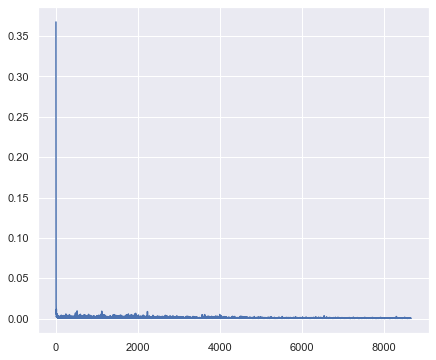

In [23]:
sns.set(rc={"figure.figsize": (7, 6)})
plt.plot(losses);

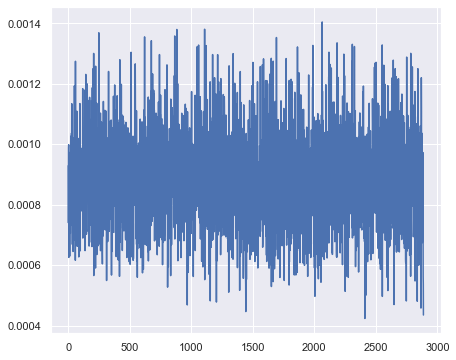

In [24]:
sns.set(rc={"figure.figsize": (7, 6)})
plt.plot(valid_losses);

In [25]:
torch.save(model, f"{models_path}\{dataset_name}")

# Check NN works

In [26]:
path_to_noised_imgs = main_data_path / "imgs_with_noise" #r"D:\Projects\PythonProjects\NIR\data\imgs_with_noise"

In [27]:
for i in range(1, 11):   
    filtering_image(model, path_to_noised_imgs, f"{i}.jpg", win_size, device)

100%|██████████| 608/608 [00:08<00:00, 71.76it/s]


In [28]:
import gc
collected = gc.collect()

In [29]:
filtered_images = r"D:\Projects\PythonProjects\NIR\data\filtered_imgs"
# convert_to_grayscale(genuine_images)


In [30]:

genuine_images = r"D:\Projects\PythonProjects\NIR\data\gray_images"

check_ssim(filtered_images, genuine_images)

1.jpg, SSIM = 0.23457181665442192
10.jpg, SSIM = 0.7278149166721435
2.jpg, SSIM = 0.41735856722034115
3.jpg, SSIM = 0.44573210435192323
4.jpg, SSIM = 0.40246734777362975
5.jpg, SSIM = 0.4140236289208228
6.jpg, SSIM = 0.5921012171486391
7.jpg, SSIM = -0.007312128207005393
8.jpg, SSIM = 0.41426664350879067
9.jpg, SSIM = 0.6860301988728323
